# Common imports

In [1]:
%matplotlib inline
#%matplotlib
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import time

# Provided functions
### Image loading and saving

In [2]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [3]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [4]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


# Add 2 params: elev, azim to change 3D viewpoint
def display_output(albedo_image, height_map, elev=20, azim=20):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d') 
    ax.view_init(elev, azim) 
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, rcount=200, ccount=200, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [5]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [6]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    # Subtract.
    processed_imarray = imarray - ambient_image[:, :, np.newaxis]
    # Set negative to zero.
    processed_imarray[processed_imarray < 0] = 0
    # Scale.
    processed_imarray = processed_imarray / 255
    
    return processed_imarray

In [7]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    # Obtain image dimensions.
    h = imarray.shape[0]
    w = imarray.shape[1]
    n_images = imarray.shape[2]
    n_pix = h * w
    
    # Reshape imarray (h x w x n_images) to (n_images, n_pix).
    imarray = imarray.reshape(n_pix, n_images).transpose()
    
    # Solve linear system to obtain g (3, n_pix).
    results = np.linalg.lstsq(light_dirs, imarray)
    g = results[0]
    
    # Solve albedo and normal.
    albedo_image = np.linalg.norm(g, axis=0)
    surface_normals = g / albedo_image
    
    # Reshape.
    surface_normals = surface_normals.transpose().reshape(h, w, 3)
    albedo_image = albedo_image.reshape(h, w)
    
    return albedo_image, surface_normals

In [8]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    # Partial derivative.
    fx = surface_normals[:, :, 0] / surface_normals[:, :, 2]
    fy = surface_normals[:, :, 1] / surface_normals[:, :, 2]
    
    row_sum_x = np.cumsum(fx, axis=1)
    col_sum_y = np.cumsum(fy, axis=0)
    
    # Four kinds of integration methods.
    def column():
        # First column, then row.
        return col_sum_y[:, 0][:, np.newaxis] + row_sum_x
    
    def row():
        # First row, then column.
        return row_sum_x[0] + col_sum_y
    
    def average():
        # Take average over column and row methods.
        return (column() + row())/2
    
    def random():
        # Flipping coins to generate random paths.
        # Only allow moving right and down, representing as follows:
        #
        #         coin  direction  height
        #            0      right     +fx
        #            1       down     +fy
        #
        # Algorithm:
        # For each pixel(x, y) except starting point(0, 0)
        #     (height of (0, 0) is always 0, don't need any path to it)
        #     For each path
        #         Flip coins of length x+y
        #         Move according to coins until reach (x, y)
        #         Add the cumsum along the path to height
        #     Take average over paths
        
        # Initialize height_map to zeros.
        h = surface_normals.shape[0]
        w = surface_normals.shape[1]
        height_map = np.zeros((h, w))
        
        # Configure number of random paths.
        n_paths = 25
        
        # Loop through each pixel.
        # Note: y is axis 0 (row), x is axis 1 (column).
        for y in range(h):
            for x in range(w):
                
                # Exclude the starting point (0, 0).
                if x != 0 or y != 0:
                    
                    for path in range(n_paths):
                        # Flip coins to generate paths.
                        # Should guarantee #zeros = x, #ones = y in coins.
                        zeros = [0] * x
                        ones = [1] * y
                        coins = np.array(zeros + ones)
                        # Randomly shuffle coins (sudo-random path).
                        np.random.shuffle(coins)
                        
                        # Starting point.
                        current_x = 0
                        current_y = 0
                        step = 0
                        cumsum = 0
                        
                        # Move along path until reach destination.
                        while current_x < x or current_y < y:
                            # Move right.
                            if coins[step] == 0:
                                cumsum += fx[current_y, current_x]
                                current_x += 1
                            else:
                                cumsum += fy[current_y, current_x]
                                current_y += 1
                            
                            step += 1
                        
                        # Add the cumsum along the path to height.
                        height_map[y, x] += cumsum
                    
                    # Take average over paths
                    height_map[y, x] = height_map[y, x]/n_paths
        return height_map
    
    method = {'average': average, 'column': column, 'row': row, 'random': random}
    
    # Compute height map and record time.
    start = time.time()
    height_map = method[integration_method]()
    end = time.time()
    print('Method used: ' + integration_method + 
          '; Time elapsed: {} s.'.format(end-start))
    
    return height_map

# Main function

## 1 Outputs for yaleB01

In [9]:
root_path = '../croppedyale/'
subject_name = 'yaleB01'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)

processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

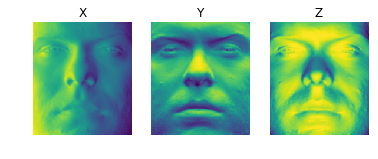

In [10]:
plot_surface_normals(surface_normals)

### 1.1 Surface height map of method `column`

Method used: column; Time elapsed: 0.0001747608184814453 s.
Surface height map of method column:
Viewpoint 1:


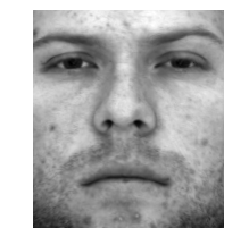

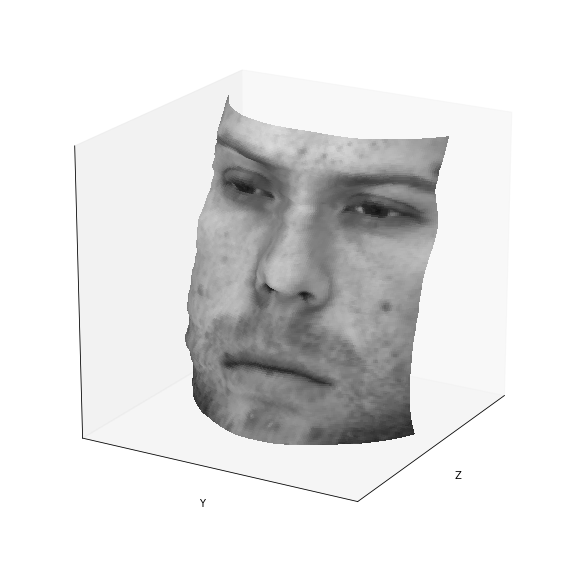

In [11]:
integration_method = 'column'
height_map = get_surface(surface_normals, integration_method)
print("Surface height map of method {}:".format(integration_method))
print("Viewpoint 1:")
display_output(albedo_image, height_map, 20, 30)

Viewpoint 2:


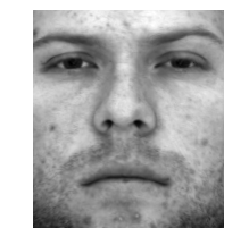

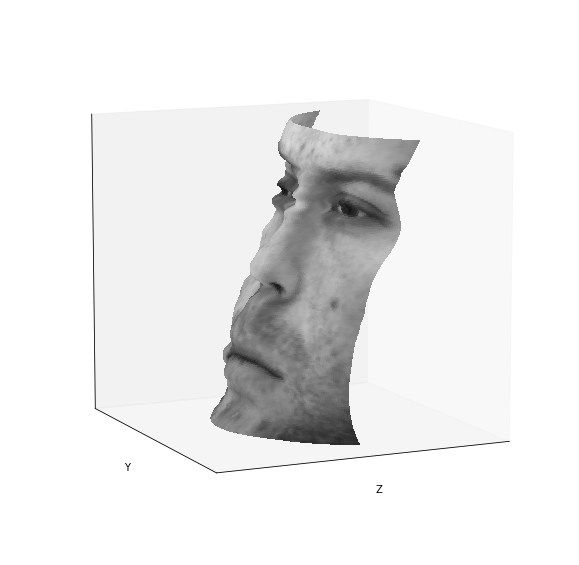

In [12]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

### 1.2 Surface height map of method `row`

Method used: row; Time elapsed: 0.00024199485778808594 s.
Surface height map of method row:
Viewpoint 1:


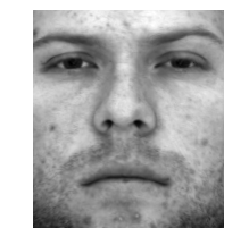

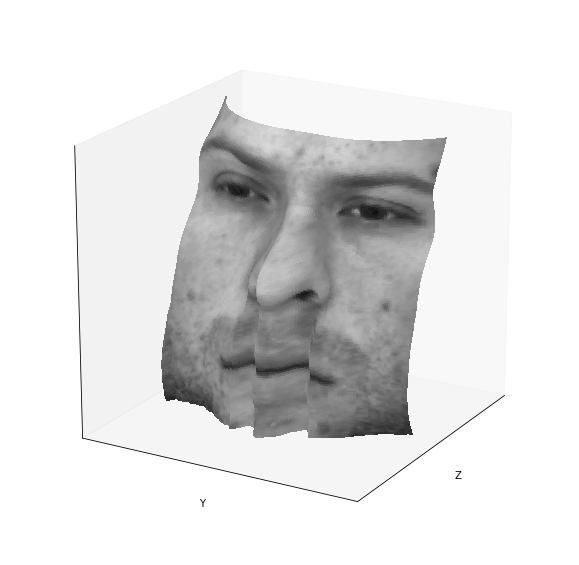

In [13]:
integration_method = 'row'
height_map = get_surface(surface_normals, integration_method)
print("Surface height map of method {}:".format(integration_method))
print("Viewpoint 1:")
display_output(albedo_image, height_map, 20, 30)

Viewpoint 2:


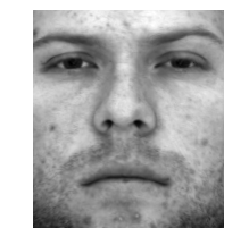

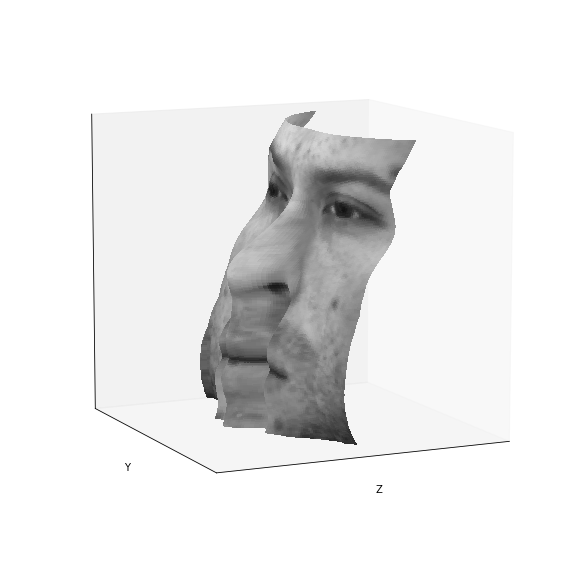

In [14]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

### 1.3 Surface height map of method `average`

Method used: average; Time elapsed: 0.0006668567657470703 s.
Surface height map of method average:
Viewpoint 1:


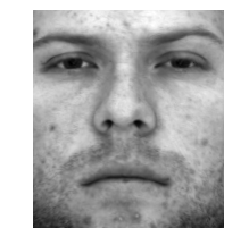

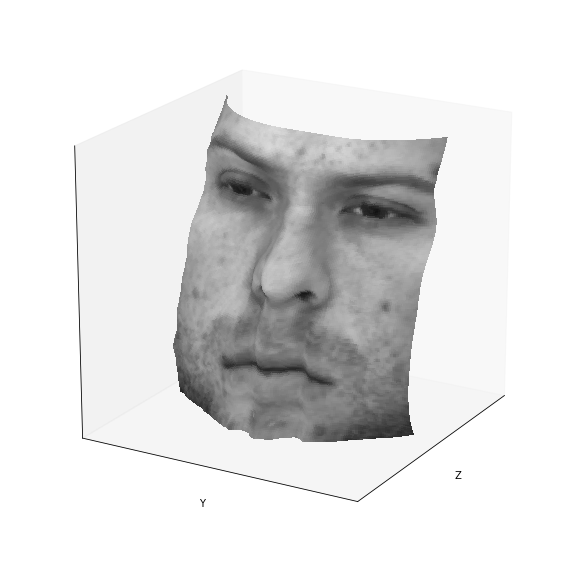

In [15]:
integration_method = 'average'
height_map = get_surface(surface_normals, integration_method)
print("Surface height map of method {}:".format(integration_method))
print("Viewpoint 1:")
display_output(albedo_image, height_map, 20, 30)

Viewpoint 2:


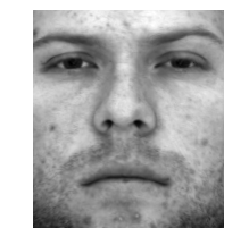

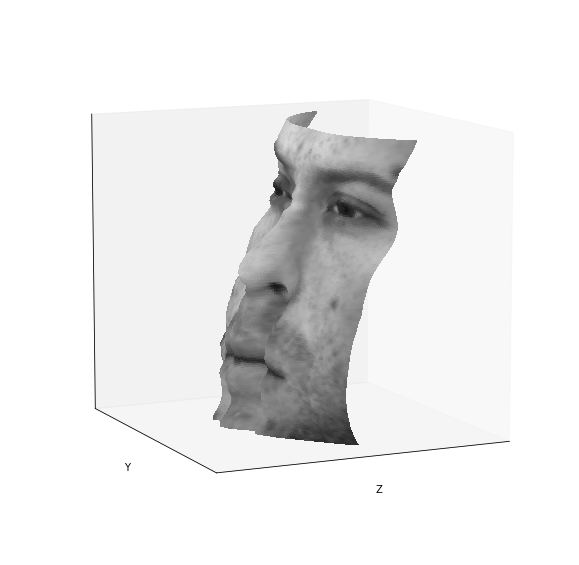

In [16]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

### 1.4 Surface height map of method `random`

Method used: random; Time elapsed: 104.20833992958069 s.
Surface height map of method random:
Viewpoint 1:


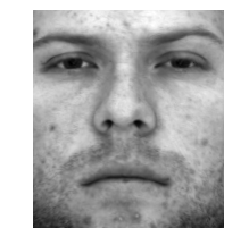

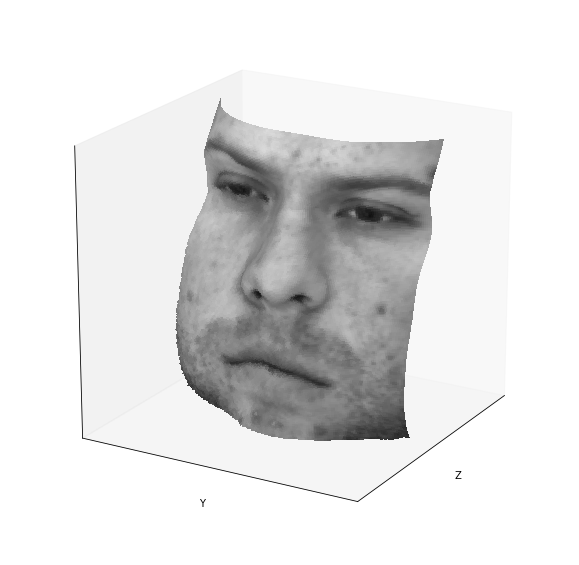

In [17]:
integration_method = 'random'
height_map = get_surface(surface_normals, integration_method)
print("Surface height map of method {}:".format(integration_method))
print("Viewpoint 1:")
display_output(albedo_image, height_map, 20, 30)

Viewpoint 2:


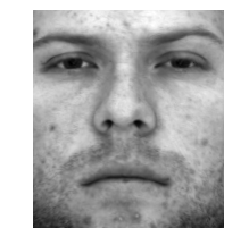

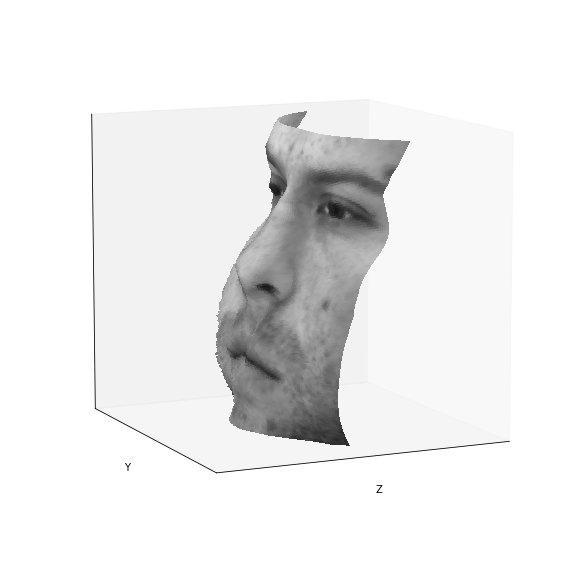

In [18]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

## 2 Outputs for yaleB02

In [19]:
root_path = '../croppedyale/'
subject_name = 'yaleB02'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)

processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

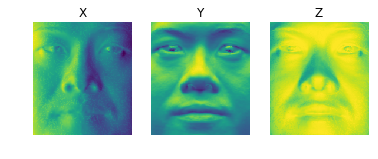

In [20]:
plot_surface_normals(surface_normals)

### 2.1 Best Surface height map 

Method used: random; Time elapsed: 99.53591799736023 s.
Surface height map of method random:
Viewpoint 1:


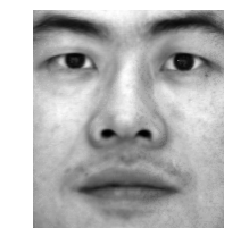

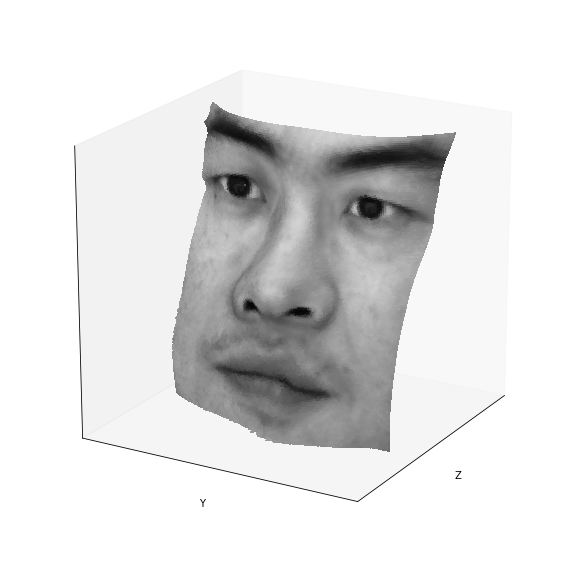

In [21]:
integration_method = 'random'
height_map = get_surface(surface_normals, integration_method)
print("Surface height map of method {}:".format(integration_method))
print("Viewpoint 1:")
display_output(albedo_image, height_map, 20, 30)

Viewpoint 2:


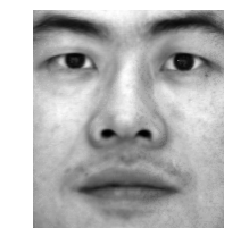

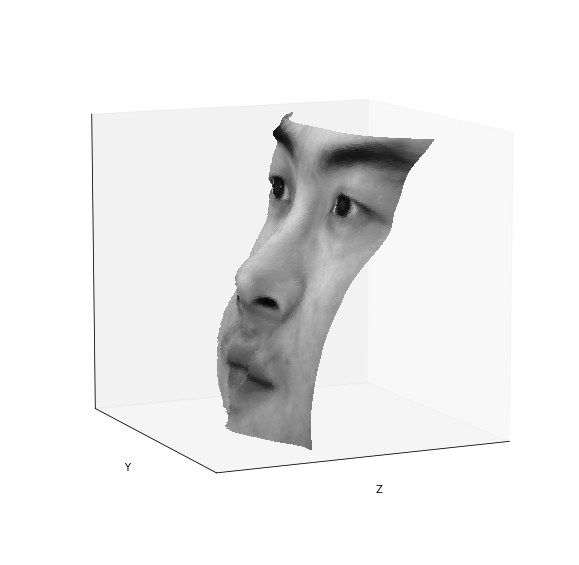

In [22]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

### 2.2 Improvement
Choosing suitable subset of pictures that excludes pictures with too much shadow.

In [23]:
def LoadFaceImages_improved(pathname, subject_name, threshold):
    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))    
    
    # Only choose images with less shadow.
    im_sub_list = []
    for fname in im_list:
        im_arr = load_image(fname)
        num_shadow = len(np.where(im_arr < 50)[0])
        ratio = num_shadow / im_arr.size
        if ratio < threshold:
            im_sub_list.append(fname)
                        
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [24]:
root_path = '../croppedyale/'
subject_name = 'yaleB02'
save_flag = False

threshold = 0.6

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages_improved(full_path, subject_name, threshold)

processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

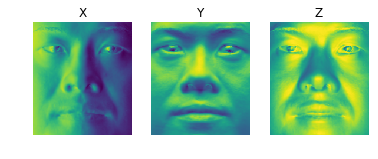

In [25]:
plot_surface_normals(surface_normals)

Method used: random; Time elapsed: 99.24893307685852 s.
Surface height map of method random:
Viewpoint 1:


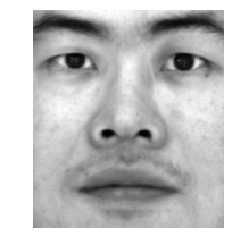

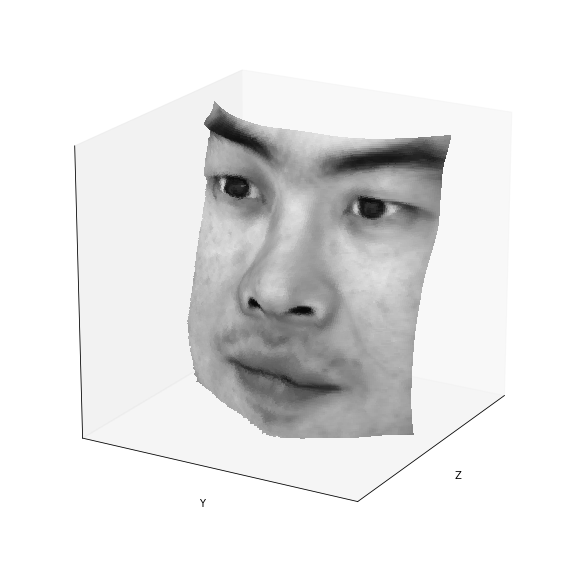

In [26]:
integration_method = 'random'
height_map = get_surface(surface_normals, integration_method)
print("Surface height map of method {}:".format(integration_method))
print("Viewpoint 1:")
display_output(albedo_image, height_map, 20, 30)

Viewpoint 2:


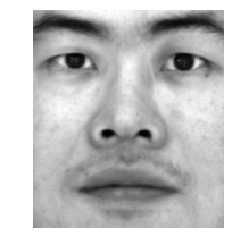

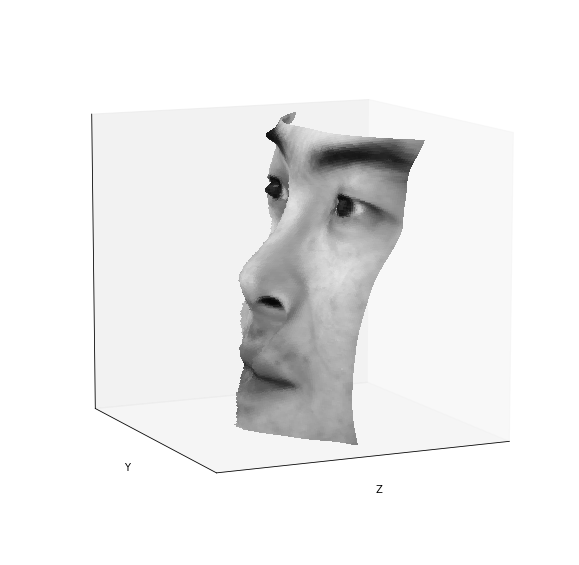

In [27]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

## 3 Outputs for yaleB05

In [28]:
root_path = '../croppedyale/'
subject_name = 'yaleB05'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)

processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

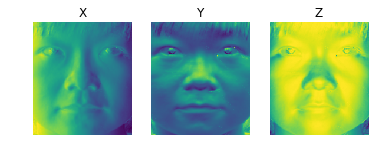

In [29]:
plot_surface_normals(surface_normals)

### 3.1 Best Surface height map 

Method used: random; Time elapsed: 99.05456209182739 s.
Surface height map of method random:
Viewpoint 1:


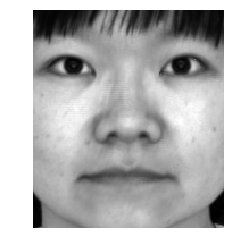

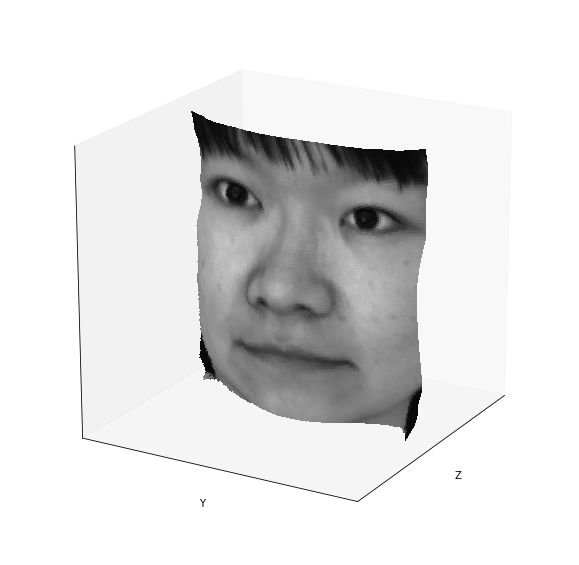

In [30]:
integration_method = 'random'
height_map = get_surface(surface_normals, integration_method)
print("Surface height map of method {}:".format(integration_method))
print("Viewpoint 1:")
display_output(albedo_image, height_map, 20, 30)

Viewpoint 2:


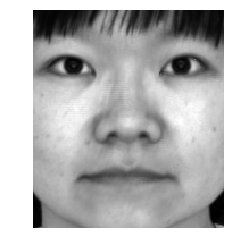

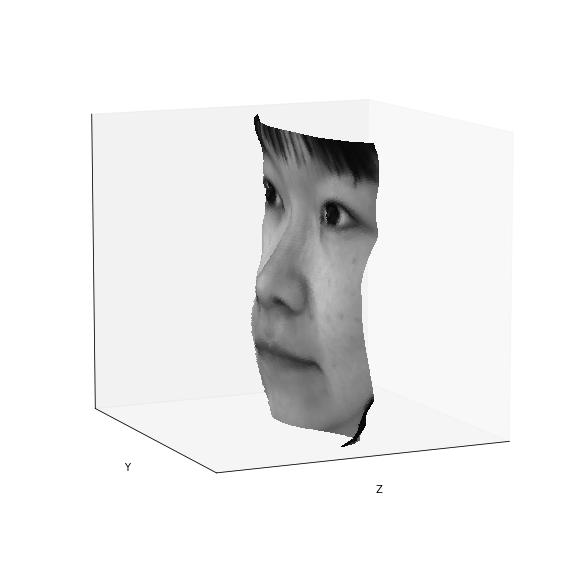

In [31]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)

## 4 Outputs for yaleB07

In [32]:
root_path = '../croppedyale/'
subject_name = 'yaleB07'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)

processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

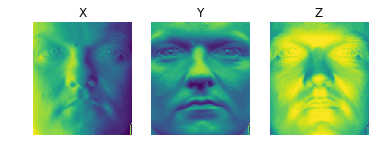

In [33]:
plot_surface_normals(surface_normals)

### 4.1 Best Surface height map 

Method used: random; Time elapsed: 107.53657412528992 s.
Surface height map of method random:
Viewpoint 1:


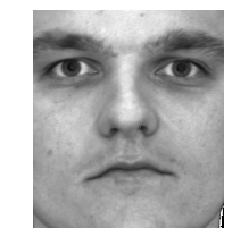

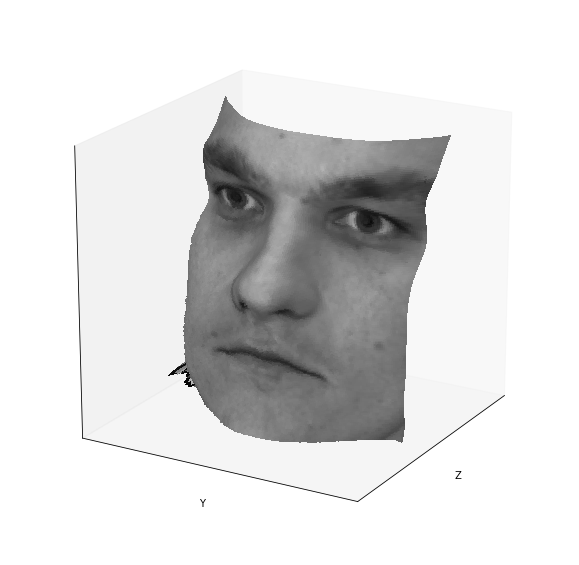

In [34]:
integration_method = 'random'
height_map = get_surface(surface_normals, integration_method)
print("Surface height map of method {}:".format(integration_method))
print("Viewpoint 1:")
display_output(albedo_image, height_map, 20, 30)

Viewpoint 2:


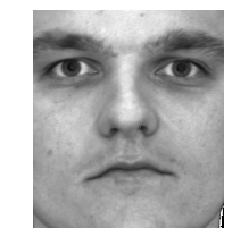

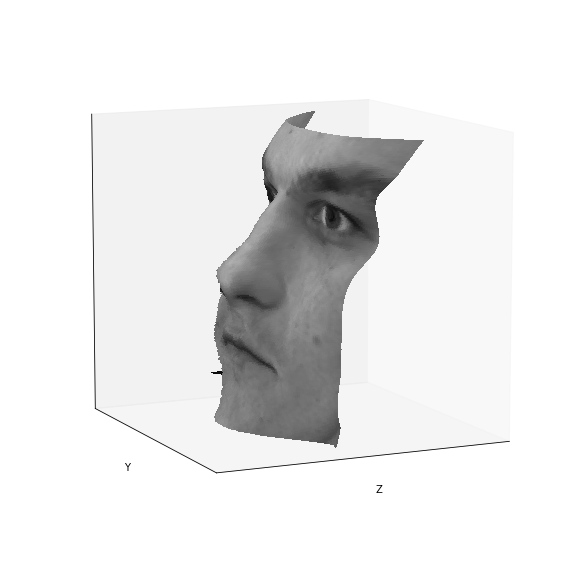

In [35]:
print("Viewpoint 2:")
display_output(albedo_image, height_map, 10, 65)